In [1]:
from IPython.display import display, Math
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

### Define function

In [2]:
def show_matrix(A):
    plt.imshow(np.abs(A))
    plt.colorbar()
    plt.title(r"$|\mathcal{T}_{\text{choi}}|$")
    plt.show()

In [3]:
def complex_ndarray_to_latex_polar(A, precision=3, tol=1e-12):
    rows = []
    for row in A:
        entries = []
        for z in row:
            r = np.abs(z)
            theta = np.angle(z)

            if r < tol:
                entries.append("0")
            elif abs(theta) < tol:
                entries.append(f"{r:.{precision}f}")
            else:
                entries.append(
                    f"{r:.{precision}f} e^{{{theta:.{precision}f}\\,\\mathrm{{i}}}}"
                )
        rows.append(" & ".join(entries))

    body = r" \\ ".join(rows)
    return r"\begin{pmatrix}" + body + r"\end{pmatrix}"

In [4]:
def apply_channel_from_choi(A, x):
    d_in = x.shape[0]
    d_out = A.shape[0] // d_in

    IxT = np.kron(np.eye(d_out), x.T)
    M = IxT @ A

    M = M.reshape(d_out, d_in, d_out, d_in)

    y = np.einsum('a i b i -> a b', M)

    return y

In [5]:
def copy_maker(x, n_copies):
    result = x
    for _ in range(n_copies - 1):
        result = np.kron(result, x)
    return result


def fidelity(x, y):
    sqrt_x = sqrtm(x)
    m = sqrt_x @ y @ sqrt_x

    sqrt_m = sqrtm(m)
    F = np.real(np.trace(sqrt_m))**2

    return F

In [6]:
def pure_state_maker(d, k):
    x = np.zeros((d, d), dtype=complex)
    x[k, k] = 1.0
    return x

def maximally_mixed_state_maker(d):
    x = np.eye(d, dtype=complex)
    x /= d
    return x

def random_mixed_state_maker(d):
    A = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    rho = A @ A.conj().T
    rho /= np.trace(rho)
    
    return rho

### Load choi operator

In [138]:
# change this parameter!!!

d = 2

method = "sdp_perm_fix"  # "sdp_fix", "sdp", "sdp_perm_fix", "sdp_perm"
n_in = 1
n_out = 8

A = np.load(f"data/{method}/{n_in}_to_{n_out}.npy")

In [139]:
x_pure = pure_state_maker(d, 0) 
y_pure = apply_channel_from_choi(A, copy_maker(x_pure, n_in))

latex_str = complex_ndarray_to_latex_polar(y_pure)
# display(Math(r"y = " + latex_str))
print("Pure state fidelity: ", fidelity(copy_maker(x_pure, n_out), y_pure))

Pure state fidelity:  0.2050546536550033


In [140]:
x_max = maximally_mixed_state_maker(d) 
y_max = apply_channel_from_choi(A, copy_maker(x_max, n_in))

latex_str = complex_ndarray_to_latex_polar(y_max)
# display(Math(r"y = " + latex_str))
print("Maximally mixed state fidelity: ", fidelity(copy_maker(x_max, n_out), y_max))

Maximally mixed state fidelity:  0.2053173947718581


In [141]:
x_rand = random_mixed_state_maker(d) 
y_rand = apply_channel_from_choi(A, copy_maker(x_rand, n_in))

latex_str_x = complex_ndarray_to_latex_polar(copy_maker(x_rand, n_out))
latex_str_y = complex_ndarray_to_latex_polar(y_rand)
# display(Math(r"x = " + latex_str_x))
# display(Math(r"y = " + latex_str_y))
print("Random mixed state fidelity: ", fidelity(copy_maker(x_rand, n_out), y_rand))

Random mixed state fidelity:  0.25598141674109365


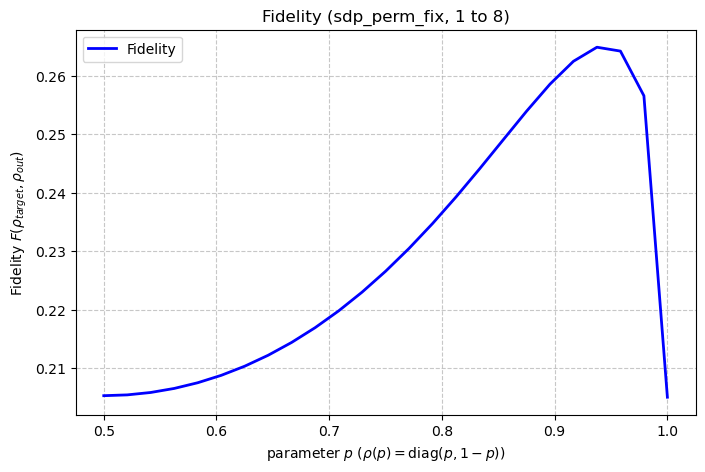

In [142]:
import numpy as np
import matplotlib.pyplot as plt

def generate_diagonal_rho(p, d):
    """
    p: 첫 번째 대각 성분의 확률 값 (0.5 <= p <= 1.0)
    d: Hilbert 공간의 차원
    """
    rho = np.zeros((d, d), dtype=complex)
    rho[0, 0] = p
    if d > 1:
        # 나머지 성분들에 대해 (1-p)를 균등 배분 (Tr(rho) = 1 유지)
        remaining_val = (1 - p) / (d - 1)
        for i in range(1, d):
            rho[i, i] = remaining_val
    return rho

# 실험 설정
p_values = np.linspace(0.5, 1.0, 25)
fidelities = []

# 기존에 정의된 d, A, n_in, n_out 변수가 존재한다고 가정함
for p in p_values:
    # 1. 대각 입력 상태 rho 생성
    rho_p = generate_diagonal_rho(p, d)
    
    # 2. 채널 적용: y = Phi(rho^{\otimes n_in})
    # 사용자의 코드 구조에 따라 copy_maker를 적용
    x_input = copy_maker(rho_p, n_in)
    y_out = apply_channel_from_choi(A, x_input)
    
    # 3. 기준 상태(Target) 생성 및 Fidelity 계산
    # 사용자의 snippet 기준: copy_maker(rho_p, n_out)와 비교
    target_state = copy_maker(rho_p, n_out)
    f = fidelity(target_state, y_out)
    
    fidelities.append(f)

# 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(p_values, fidelities, label='Fidelity', color='blue', linewidth=2)
plt.xlabel(r'parameter $p$ ($\rho(p) = \mathrm{diag}(p, 1-p)$)')
plt.ylabel(r'Fidelity $F(\rho_{target}, \rho_{out})$')
plt.title(f'Fidelity ({method}, {n_in} to {n_out})')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig(f"figure/fidelity_{method}_{n_in}_to_{n_out}.png")
plt.show()